In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
L_x = 100
g = 9.81
H = 100

N_x = 301
dx = L_x/(N_x - 1)
dt = 0.002
N_t = 50000
err = 1e-4
x = np.linspace(0,L_x,N_x)
h = np.zeros(N_x)
u = np.zeros(N_x)
D = 100
slope = lambda x: 0.7*(x>700)*(x-700)
# slope = lambda x: 0.2*x

b = slope(x)
H = D - b
b_ = np.zeros(N_x)
# b = np.zeros(N_x)
# h = 10*np.exp(-((x)**2/(2*(0.05E+3)**2)))
h[int(1*N_x/16):int(2*N_x/8)] = 50
nu = 0.01

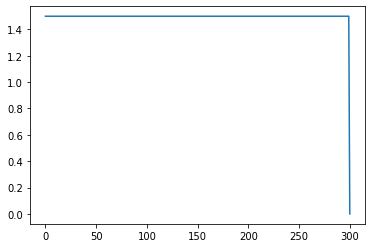

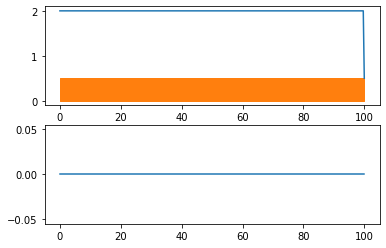

In [3]:
h = np.ones(N_x)*0.5

h[:300]= 2
slope = lambda x,b,L: (x>=b)*(x-b)*(L/(L_x-b))
dam  = lambda x,a,b,L: ((x>=a)&(x<=b))*L

u = np.zeros(N_x)
z = np.ones(N_x)*0.5
s = slope(x,90,2)
d = dam(x,20,30,3)
z = z
z_ = np.zeros(N_x)

h = np.where(h>=z,h-z,0)
plt.plot(h)
plt.show()
# z[150:200]=0
fig, (axh,axu) = plt.subplots(2, 1,facecolor ='white')
line_u,=axu.plot(x,u)
line_h,=axh.plot(x,h+z)
fill_=axh.fill_between(x,z,z_,color ='tab:orange')

In [4]:
N_x = 200-1 # for Fx,and Px
N_z = 200-1  # for Fz,and Pz

U_x = N_x + 2 
U_z = N_z

W_x = N_x
W_z = N_z + 2

L_x = 100
L_z = 100

# U = np.zeros((U_x,U_y+2)) # N_x+2, N_y    , N_x [0,last] =0,and if you N_y +2 for convinient, so -1, max+ 1 also 0 for BC
# V = np.zeros((V_x+2,V_y)) # N_x  , N_y + 2, N_y [0,last] =0,and if you N_x +2 for convinient, so -1, max+ 1 also 0 for BC


# x = np.linspace(0,L_x,U_x,endpoint=True) # contain the boundary, make the all area
# y = np.linspace(0,L_y,V_y,endpoint=True) # contain the boundary, make the all area
# X,Y = np.meshgrid(x,y,indexing='ij')



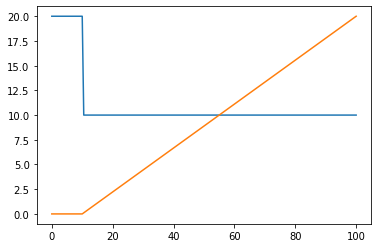

In [5]:
U = np.zeros((U_x,U_z+2)) # N_x+2, N_z    , N_x [0,last] =0,and if you N_z +2 for convinient, so -1, max+ 1 also 0 for BC
W = np.zeros((W_x+2,W_z)) # N_x  , N_z + 2, N_z [0,last] =0,and if you N_x +2 for convinient, so -1, max+ 1 also 0 for BC


x = np.linspace(0,L_x,U_x,endpoint=True) # contain the boundary, make the all area
z = np.linspace(0,L_z,W_z,endpoint=True) # contain the boundary, make the all area
X,Z = np.meshgrid(x,z,indexing='ij')
dx, dz = L_x/(N_x+1), L_z/(N_z+1)
slope = lambda x,b,L: (x>=b)*(x-b)*(L/(L_x-b))
B_X = slope(X,10,20)
# plt.plot(x,slope(x,0,20))
height = lambda x,b,h1,h2: (x<=b)*(h1) + (x>b)*(h2)
H_X = height(X,10,30,20)
BC = np.where(((X==0)|(X == L_x)|(Z==0)|(Z==L_z)))
FC = np.where(((X==0)|(X == L_x)|(Z==0)|(Z==L_z)|(Z<=H_X)|(Z<=B_X)))
FC_not = np.where(~((X==0)|(X == L_x)|(Z==0)|(Z==L_z)|(Z<=H_X)|(Z<=B_X)))
TC = np.where(((X==0)|(X == L_x)|(Z==0)|(Z==L_z)|(Z<=B_X))) # Topology condition

HC = np.where((Z<=H_X)&(Z>=B_X))

# plt.imshow(x, height(x,10,10,20))
# plt.imshow(H_x.T,vmin=0, vmax= 100)
plt.plot(x,height(x,10,20,10))
plt.plot(x,slope(x,10,20))

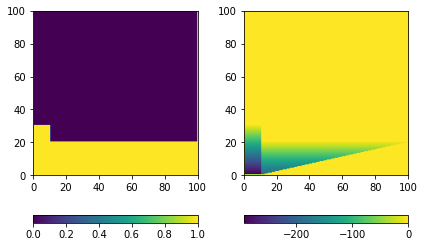

In [6]:
# set pressure by height

F = np.zeros_like(U)
F[TC] = 1
F[HC] = 1
# BC = np.where(Y<B_X)
# U[BC] = 0
plt.subplot(121)
plt.imshow(F.T,extent=[0,L_x,0,L_z],origin='lower')
plt.colorbar(orientation="horizontal")
# set pressure by height
P = np.zeros_like(U)
P[HC] = -g*dz
# P[TC_not] = 0
for i in range(N_z-1,-1,-1):P[:,i-1]+=P[:,i]
P[TC] = 0
plt.subplot(122)
plt.imshow(P.T,extent=[0,L_x,0,L_z],origin='lower')
plt.colorbar(orientation="horizontal")
plt.tight_layout()

In [7]:
from numba import jit

In [8]:
def padding_2D(UC,axis='x',HOW ='edge'):
    if axis == 'x':
        if HOW == 'constant':
            U_pad = np.pad(UC,((1,1),(0,0)),'constant',constant_values = 0)
        else:
            U_pad = np.pad(UC,((1,1),(0,0)),'edge')
        UW = U_pad[:-2,:]
        UE = U_pad[2:,:]
        return UW,UC,UE
    if axis == 'z':
        if HOW == 'constant':
            U_pad = np.pad(UC,((0,0),(1,1)),'constant',constant_values = 0)
        else:
            U_pad = np.pad(UC,((0,0),(1,1)),'edge')
        UN = U_pad[:,2:]
        US = U_pad[:,:-2]
        return US,UC,UN


def set_dt(U,W,dx,dz,dt,c_num,err=1e-5):
    dx_u = dx/np.max(U)
    dz_w = dz/np.max(W)
    newdt = min(c_num*dx_u,c_num*dz_w,dt)
    newdt = max(newdt,err)
    return newdt

def NS_solver(U,W,P,F,dx,dz,dt,nu,beta0=1.7,c_num = 0.7,g=g):
    UW,UC,UE = padding_2D(U.copy(),'x','constant')
    WS,WC,WN = padding_2D(W.copy(),'z','constant')
    PN = P.copy()
    D = (-(1/dx)*(UC - UW) + (1/dz)*(WC-WS))
    beta = beta0/(2*dt*(1/(dx*dx) + 1/(dz*dz)))
    dP = beta*D
    dPW,dPC,dPE = padding_2D(dP,'x','constant')
    dPS,dPC,dPN = padding_2D(dP,'z','constant')
    P = PN+dP
    # P[TC] = 0
    UC = UC + (dt/dx)*(dPC - dPW)
    WC = WC + (dt/dz)*(dPC - dPS)
    # UC[TC] = 0
    # WC[TC] = 0
    
    UW,UC,UE = padding_2D(UC.copy(),'x','constant')
    US,UC,UN = padding_2D(UC.copy(),'z','constant')
    WW,WC,WE = padding_2D(WC.copy(),'x','constant')
    WS,WC,WN = padding_2D(WC.copy(),'z','constant')
    
    UiC = (UC + UW)/2
    UiCE = (UE + UC)/2
    WiC = (WC + WS)/2
    WiCN = (WN + WC)/2
    UUup = np.where(UiC>=0,UW,UC)
    UUupE = np.where(UiCE>=0,UC,UE)
    
    FUX = (UiCE*UUupE - UiC*UUup)*dx
    
    UWup = np.where(WiC>=0,US,UC)
    UWupN = np.where(WiCN>=0,UC,UN)
    
    FUZ = (WiCN*UWupN-WiC*UWup)*dz
    

    WUup = np.where(UiC>=0,WW,WC)
    WUupE = np.where(UiCE>=0,WC,WE)
    
    FWX = (UiCE*WUupE - UiC*WUup)*dx
    
    Wup = np.where(WiC>=0,WS,WC)
    WupN = np.where(UiCE>=0,WC,WN)
    
    FWZ = (WiCN*WupN-WiC*Wup)*dz
    
    VISX = nu*((1/(dx*dx))*(UE - 2*UC + UN) + (1/(dz*dz))*(UN - 2*UC + UW))
    VISZ = nu*((1/(dx*dx))*(WE - 2*WC + WN) + (1/(dz*dz))*(WN - 2*WC + WW))
    
    PW,PC,PE = padding_2D(P.copy(),'x','constant')
    PS,PC,PN = padding_2D(P.copy(),'z','constant')
    PX = (PC - PW)/dx
    PZ = (PC - PS)/dz
    
    U = UC + dt*(-PX - FUX - FUZ + VISX) 
    W = WC + dt*(-PZ - FWX - FWZ + VISZ - g) 
    new_dt = set_dt(U,W,dx,dz,dt,c_num)
    P[TC] = 0
    U[TC] = 0
    W[TC] = 0
    return U,W,P,new_dt
    

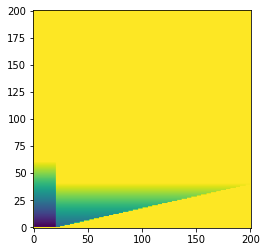

In [9]:
UW,UC,UE = padding_2D(U.copy(),'x')
WS,WC,WN = padding_2D(W.copy(),'z')
PN = P.copy()
D = (-(1/dx)*(UC - UW) + (1/dz)*(WC-WS))
beta0 = 1.7
beta = beta0/(2*dt*(1/(dx*dx) + 1/(dz*dz)))
dP = beta*D
plt.imshow((PN).T, origin='lower')

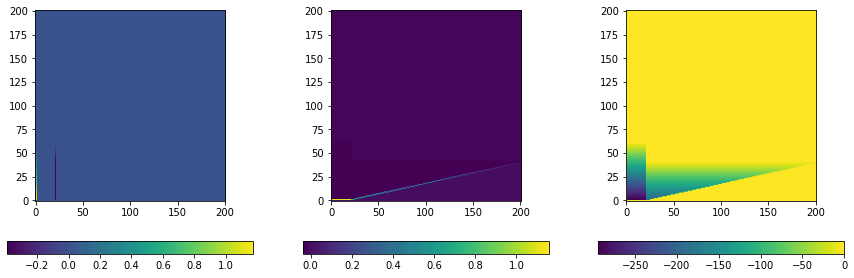

In [10]:
Unew,Wnew,Pnew, newdt = NS_solver(U,W,P,F,dx,dz,dt,nu,1e-6,c_num=0.1)

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(Unew.T,origin='lower')
plt.colorbar(orientation="horizontal")
plt.subplot(132)
plt.imshow(Wnew.T,origin='lower')
plt.colorbar(orientation="horizontal")
plt.subplot(133)
plt.imshow(Pnew.T,origin='lower')
plt.colorbar(orientation="horizontal")

In [12]:
T_list =[]

C:\Users\kim9y\AppData\Local\Temp\ipykernel_11180\2207789274.py:55: RuntimeWarning: overflow encountered in multiply
  FUX = (UiCE*UUupE - UiC*UUup)*dx
C:\Users\kim9y\AppData\Local\Temp\ipykernel_11180\2207789274.py:55: RuntimeWarning: invalid value encountered in subtract
  FUX = (UiCE*UUupE - UiC*UUup)*dx
C:\Users\kim9y\AppData\Local\Temp\ipykernel_11180\2207789274.py:60: RuntimeWarning: overflow encountered in multiply
  FUZ = (WiCN*UWupN-WiC*UWup)*dz
C:\Users\kim9y\AppData\Local\Temp\ipykernel_11180\2207789274.py:60: RuntimeWarning: invalid value encountered in subtract
  FUZ = (WiCN*UWupN-WiC*UWup)*dz
C:\Users\kim9y\AppData\Local\Temp\ipykernel_11180\2207789274.py:66: RuntimeWarning: overflow encountered in multiply
  FWX = (UiCE*WUupE - UiC*WUup)*dx
C:\Users\kim9y\AppData\Local\Temp\ipykernel_11180\2207789274.py:66: RuntimeWarning: invalid value encountered in subtract
  FWX = (UiCE*WUupE - UiC*WUup)*dx
C:\Users\kim9y\AppData\Local\Temp\ipykernel_11180\2207789274.py:71: RuntimeWa

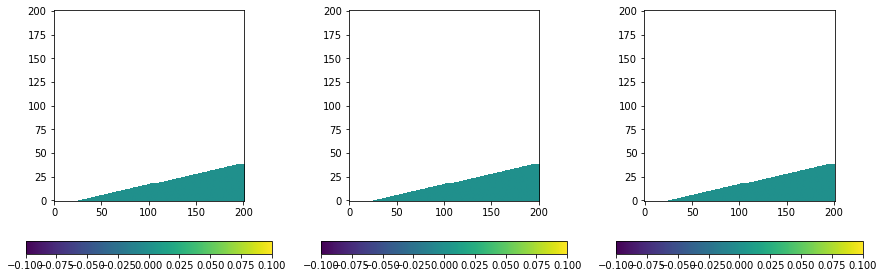

In [21]:
for i in range(100):
    T_list.append(newdt)
    Unew,Wnew,Pnew, newdt = NS_solver(Unew,Wnew,Pnew,F,dx,dz, newdt,nu,1e-6,c_num=0.7)

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(Unew.T,origin='lower')
plt.colorbar(orientation="horizontal")
plt.subplot(132)
plt.imshow(Wnew.T,origin='lower')
plt.colorbar(orientation="horizontal")
plt.subplot(133)
plt.imshow(Pnew.T,origin='lower')
plt.colorbar(orientation="horizontal")


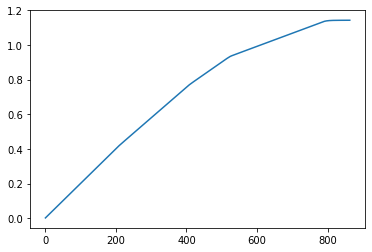

In [31]:
plt.plot(np.cumsum(T_list))